In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)
sys.path.append(os.path.join(parent_folder_path, 'simulator'))
sys.path.append(os.path.join(parent_folder_path, 'equities/data_processing'))

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np
import pandas as pd
import random
from typing import List, Tuple, Union
from copy import deepcopy
from tqdm import tqdm
from glob import glob
from datetime import datetime
from matplotlib import pyplot as plt
from contextlib import nullcontext
import torch

from simulator.core import Message
from simulator.core.utils import str_to_ns, fmt_ts
from simulator.markets.order_book import OrderBook
from simulator.markets.orders import LimitOrder, Side, MarketOrder
from equities.data_processing import itch_preproc
from equities.data_processing import itch_encoding
# from equities.model import GPTConfig, GPT
from equities.fast_model import Transformer, ModelArgs
from equities.data_processing import itch_encoding

In [3]:
# INIT PARAMS
# -----------------------------------------------------------------------------
# init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
# out_dir = parent_folder_path + '/out' # ignored if init_from is not 'resume'
# checkpoint = parent_folder_path + '/out/ckpt.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v2.pt'
# checkpoint =  parent_folder_path + '/out/ckpt_fast_v4.pt'
checkpoint =  parent_folder_path + '/out/ckpt_fast_v5.pt'

# dataset = '12302019.NASDAQ_ITCH50_AAPL_message_proc.npy' # dataset to use for initial prompt
# start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
msgs_to_load_LOB = 287500 # 10am # 15700 # 9:30am # number of initial messages to load LOB with
num_context_msgs = 100 # 400 # number of messages from dataset to use as context
# num_samples = 10 # number of samples to draw
num_samples = 1 # number of samples to draw (think of like monte carlo paths)
# max_new_tokens = 500 # number of tokens generated in each sample
max_new_tokens = 1 # number of tokens generated in each sample (think of like time steps)
temperature = 1.1 # 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
# top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
top_k = 300 # 100 # retain only the top_k most likely tokens, clamp others to have 0 probability
top_p = 0.95 # keep the top tokens with cumulative probability >= top_p (nucleus filtering)
assert 0.0 <= top_p <= 1.0
seed = 42
vocab = itch_encoding.Vocab()
use_sink = True # if True, use a dedicated sink token at the start of every training sample (per https://arxiv.org/pdf/2309.17453.pdf)
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
quantize = False # quantize the model to int8
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


In [4]:
TIME = 0
WORLD_AGENT_ID = 1

class FakeExchangeAgent:
    def __init__(self):
        self.messages = []
        self.current_time = TIME
        self.mkt_open = TIME
        self.book_logging = None
        self.stream_history = 10

    def reset(self):
        self.messages = []

    def send_message(self, recipient_id: int, message: Message, _: int = 0):
        self.messages.append((recipient_id, message))

    def logEvent(self, *args, **kwargs):
        pass

In [5]:
# define load paths
raw_itch_load_path = parent_folder_path + '/dataset/raw/ITCH/'
processed_dataset = '03272019.NASDAQ_ITCH50_AAPL_message_proc.npy'
proc_data_dir = os.path.join('dataset/proc/ITCH/full_view/', processed_dataset)
proc_data_dir = parent_folder_path + '/' + proc_data_dir
symbols_load_path = parent_folder_path + '/dataset/symbols/'
symbols_file = sorted(glob(symbols_load_path + '*sp500*.txt'))[0]

# locate raw ITCH data
itch_message_files = sorted(glob(raw_itch_load_path + '*message*.csv'))
itch_book_files = sorted(glob(raw_itch_load_path + '*book*.csv'))
print('found', len(itch_message_files), 'ITCH message files')
print('found', len(itch_book_files), 'ITCH book files')

# create reverse ticker symbol mapping (key is index, value is ticker)
tickers = {}
with open(symbols_file) as f:
    idx = 0
    for line in f:
        idx += 1
        tickers[idx] = line.strip()

# load raw ITCH data (book)
symbols = []
for m_f, b_f in tqdm(zip(itch_message_files, itch_book_files)):
    if '03272019' not in m_f:
        continue
    print(m_f)
    
    first_message = (itch_preproc.load_message_df(m_f)).iloc[0]

    # symbol to store in list and use to create OB objects in loop later
    symbol = m_f.rsplit('/', maxsplit=1)[-1][:-12].rsplit('_', maxsplit=1)[-1]
    print("Adding symbol:", symbol)
    symbols.append(symbol)

# load processed ITCH data (messages)
# proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:num_context_msgs])
# proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(12749 + num_context_msgs)])\
proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(msgs_to_load_LOB + num_context_msgs)])
print("proc_messages.shape:", proc_messages.shape)
# print("proc_messages:", proc_messages)
print([ "ticker", "order_id",
        "event_type", "direction", "price_abs", "price", "fill_size", "remain_size",
        "delta_t_s", "delta_t_ns", "time_s", "time_ns", "old_id",
        "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])

found 8 ITCH message files
found 8 ITCH book files


0it [00:00, ?it/s]

/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/03272019.NASDAQ_ITCH50_AAPL_message.csv


8it [00:00, 13.97it/s]

Adding symbol: AAPL
proc_messages.shape: (287600, 18)
['ticker', 'order_id', 'event_type', 'direction', 'price_abs', 'price', 'fill_size', 'remain_size', 'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns', 'old_id', 'price_ref', 'fill_size_ref', 'time_s_ref', 'time_ns_ref', 'old_price_abs']


In [6]:
print(proc_messages[-5:])
enc_msgs = itch_encoding.encode_msgs(proc_messages[-5:], vocab.ENCODING)
itch_encoding.decode_msgs(enc_msgs, vocab.ENCODING)

[[       40  45074349         4         1     18854         3       100
          0         0    152256     36000 748271607     -9999         2
        100     36000 147292116     -9999]
 [       40  45092033         1         1     18852         1       100
      -9999         0      4175     36000 748275782     -9999     -9999
      -9999     -9999     -9999     -9999]
 [       40  45092025         4         1     18852         1       100
          0         0   1167861     36000 749443643     -9999         1
        100     36000 748119351     -9999]
 [       40  45093357         1         0     18826       -25       100
      -9999         0  50268164     36000 799711807     -9999     -9999
      -9999     -9999     -9999     -9999]
 [       40  44027777         4         1     18881        30       100
          0         0   9479538     36000 809191345     -9999        27
        100     35940 226326577     -9999]]


array([[       40,     -9999,         4,         1,     -9999,         3,
              100,         0,         0,    152256,     36000, 748271607,
            -9999,         2,       100,     36000, 147292116,     -9999],
       [       40,     -9999,         1,         1,     -9999,         1,
              100,     -9999,         0,      4175,     36000, 748275782,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [       40,     -9999,         4,         1,     -9999,         1,
              100,         0,         0,   1167861,     36000, 749443643,
            -9999,         1,       100,     36000, 748119351,     -9999],
       [       40,     -9999,         1,         0,     -9999,       -25,
              100,     -9999,         0,  50268164,     36000, 799711807,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [       40,     -9999,         4,         1,     -9999,        30,
              100,         0,     

In [7]:
# ex_msg = proc_messages[-1]
# print(ex_msg)

# time_s = ex_msg[10]
# time_ns = ex_msg[11]
# # encoding = encoding,
# delta_t_s = ex_msg[8]
# delta_t_ns = ex_msg[9]

# print(vocab.ENCODING['time'])

# # split_field(delta_t_ns, 3, 3, False)
# n_tokens = 3
# tok_len = 3

# print("delta_t_ns: ", delta_t_ns)

# total_tokens = n_tokens + int(False)
# print("total_tokens: ", total_tokens)

# # split_field(x, n_tokens, tok_len, prepend_sign_token=False)
# # split_int(x, n_tokens, tok_len, prepend_sign_token)

# delta_t_ns = np.abs(delta_t_ns)
# base = 10
# n_digits = n_tokens * tok_len
# div_exp = np.flip(
#     np.arange(0, n_digits, tok_len))
# splits = (delta_t_ns // (base ** div_exp)) % (10**tok_len)
# print("splits: ", splits)

# itch_encoding.encode([splits], *vocab.ENCODING['time'])

In [8]:
# init new book under nasdaq agent
nasdaq_agent = FakeExchangeAgent()

# create a dictionary of order books based on each symbol in symbols
print("Creating order books for symbols:", symbols)
order_books = {}
for symbol in symbols:
    order_books[symbol] = OrderBook(nasdaq_agent, symbol)

# empty book
assert order_books[tickers[proc_messages[0][0]]].bids == order_books[tickers[proc_messages[0][0]]].asks == []

Creating order books for symbols: ['AAPL']


In [9]:
# first message is missing in proc_messages, so we'll use the raw message file to start the book
print(first_message)

# insert bid order
bid_order = LimitOrder(
    order_id=first_message['id'],
    agent_id=1, # world agent, leave alone for now
    time_placed=first_message['time'],
    symbol=symbols[0],
    quantity=int(first_message['size']),
    side=Side.BID if first_message['side'] == 0 else Side.ASK,
    limit_price=int(first_message['price']*100),
)
order_books[symbols[0]].handle_limit_order(bid_order)

print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())
nasdaq_agent.messages

time        14400006432545
type                     A
id                   13301
side                     1
size                  18.0
price               207.85
cancSize               NaN
execSize               NaN
oldId                  NaN
oldSize                NaN
oldPrice               NaN
mpid                   NaN
Name: 0, dtype: object
L3 bid data: []
L3 ask data: [(20785, [18])]


[(1,
  OrderAcceptedMsg(message_id=1, order=(Agent 1 @ 1970-01-01 04:00:00) : ASK 18 AAPL @ $207.85))]

In [10]:
# INIT ORDER BOOKS FROM PROCESSED CONTEXT DATA

# [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]

# init variables to keep track of previous time, price, etc.
prev_time = first_message['time']
prev_price = int(first_message['price']*100)
L1 = [] # list to store L1 data for plotting
last_prices = [] # list to store last prices for plotting

# iterate through messages and update order books
for msg in proc_messages:
    # print(msg)
    symbol = tickers[msg[0]]
    # print("Symbol:", symbol)
    order_id = msg[1]
    # print("Order ID:", order_id)
    event_type = msg[2]
    # print("Event Type:", event_type)
    price = msg[4]
    # print("Price:", price)

    # verify time correctness
    assert prev_time + (msg[8]*1000000000) + msg[9] == (msg[10] * 1000000000) + msg[11]
    time = prev_time + (msg[8]*1000000000) + msg[9]
    # print("Time:", time)

    # handle order based on event type
    if event_type == 1:
        # ADD LIMIT ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].handle_limit_order(order)
    elif event_type == 2:
        # EXECUTE ORDER
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        order = MarketOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(order)
    elif event_type == 3:
        # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
        # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
        # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
        # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

        # modfify the matched limit order
        direction = Side.BID if msg[3] == 0 else Side.ASK
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order_size = msg[14]
        ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # define original order
        original_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=ref_order_time,
            symbol=symbol,
            quantity=ref_order_size,
            side=direction,
            limit_price=ref_order_price,
        )
        # define modified order
        # modified_price = msg[4]
        modified_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=ref_order_time,
            symbol=symbol,
            quantity=ref_order_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].modify_order(original_order, modified_order)
        # execute the modified order
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        order = MarketOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(order)
    elif event_type == 4:
        # CANCEL ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        if msg[7] == 0:
            # FULL DELETION
            fill_size = msg[6]
            # print("Cancel Size:", fill_size)
            order = LimitOrder(
                order_id=order_id,
                agent_id=1, # world agent, leave alone for now
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=fill_size,
                # quantity=msg[14], # total size of order when placed
                side=direction,
                limit_price=price,
            )
            order_books[symbol].cancel_order(order)
        else:
            # PARTIAL CANCELLATION
            cancel_size = msg[6]
            # print("Partial Cancel Size:", cancel_size)
            ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
            order = LimitOrder(
                order_id=order_id,
                agent_id=1, # world agent, leave alone for now
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=ref_order_size,
                side=direction,
                limit_price=price,
            )
            order_books[symbol].partial_cancel_order(order, cancel_size)
    elif event_type == 5:
        # REPLACE ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        old_order_id = msg[12]
        old_order_time = (msg[15] * 1000000000) + msg[16]
        old_order_size = msg[14]
        old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # define old order
        old_order = LimitOrder(
            order_id=old_order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=old_order_time,
            symbol=symbol,
            quantity=old_order_size,
            side=direction,
            limit_price=old_order_price,
        )
        new_order_size = msg[6]
        # define new order
        new_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=new_order_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].replace_order(1, old_order, new_order) # first arg is agent_id (world agent)
    else:
        raise NotImplementedError("Event type not implemented")

    # update previous time and price
    prev_time = time
    prev_price = price

    # update plotting variables
    L1.append((time, order_books[symbol].get_l1_bid_data(), order_books[symbol].get_l1_ask_data()))
    if event_type in [2, 3]:
        last_prices.append((time, price))
    
# print end result
print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())

L3 bid data: [(18850, [78, 241]), (18849, [300]), (18848, [100, 500]), (18847, [400]), (18846, [300, 100, 100]), (18844, [100, 100, 100]), (18843, [100]), (18842, [100, 100]), (18841, [100]), (18840, [300, 100, 100, 100, 53, 100]), (18839, [1500, 100]), (18838, [400, 100, 100]), (18837, [800, 200, 100, 100]), (18836, [100, 100]), (18835, [10]), (18834, [100]), (18833, [58]), (18832, [50, 100, 100]), (18831, [1]), (18830, [10, 10, 1, 40, 100]), (18829, [60, 100]), (18828, [100, 100]), (18827, [50, 100]), (18826, [200, 100, 53, 100]), (18825, [10, 4, 2, 10, 10, 1, 100, 8, 100]), (18824, [250, 30, 100]), (18823, [8]), (18822, [100, 17]), (18820, [15, 2, 1, 10, 20, 100, 40, 10]), (18819, [18, 10]), (18818, [1]), (18817, [1, 10, 100]), (18815, [1, 25, 10]), (18812, [100]), (18811, [1, 1, 150]), (18810, [3, 1, 6, 200, 6]), (18808, [3]), (18807, [100]), (18805, [10]), (18804, [312]), (18802, [10, 100]), (18801, [300, 50, 1000]), (18800, [4, 1, 20, 100, 10, 10, 3, 1, 1, 1, 24, 80, 100, 9, 1, 5

len(L1): 287600


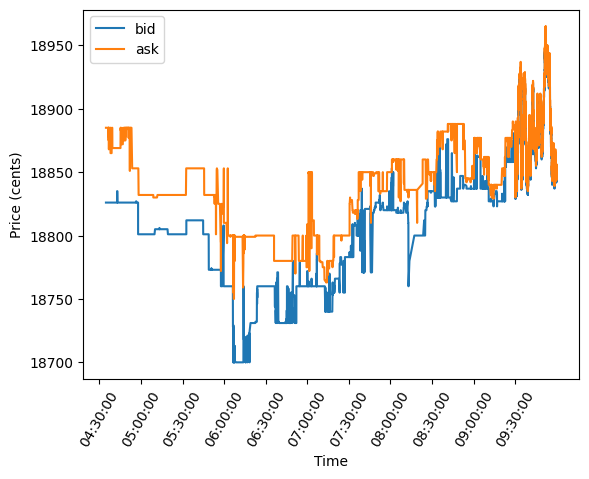

In [11]:
print("len(L1):", len(L1))

# plot L1 data
times = [L1[i][0] for i in range(len(L1))]
bids = [L1[i][1][0] for i in range(len(L1))]
asks = [L1[i][2][0] for i in range(len(L1))]
# plt.plot(times, bids, label='bid')
# plt.plot(times, asks, label='ask')

# plot recent time steps
# plt.plot(times[-14000:], bids[-14000:], label='bid')
# # plt.plot(times[-14000:], asks[-14000:], label='ask')
plt.plot(times[-286000:], bids[-286000:], label='bid')
plt.plot(times[-286000:], asks[-286000:], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
# plt.show()

time_mesh = np.arange(
    str_to_ns("04:30:00"),
    # str_to_ns("09:30:00"),
    str_to_ns("10:00:00"),
    1e9*60*30 # last number is minutes increment (every 30 minutes in this case)
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

len(last_prices): 9106


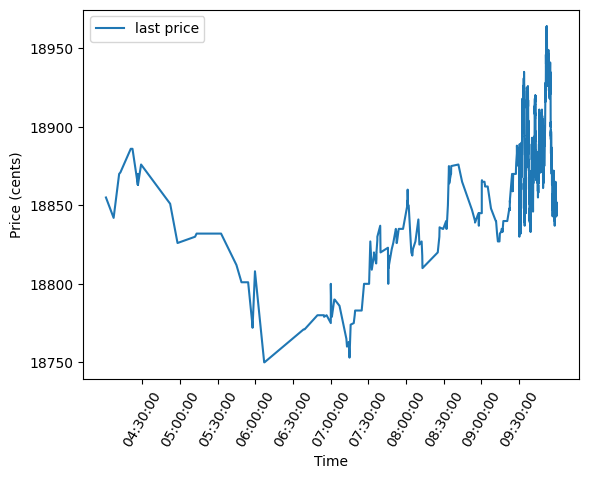

In [12]:
print("len(last_prices):", len(last_prices))

# plot last prices
times = [last_prices[i][0] for i in range(len(last_prices))]
prices = [last_prices[i][1] for i in range(len(last_prices))]
plt.plot(times, prices, label='last price')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
# plt.show()

time_mesh = np.arange(
    str_to_ns("04:30:00"),
    # str_to_ns("09:30:00"),
    str_to_ns("10:00:00"),
    1e9*60*30 # last number is minutes increment (every 30 minutes in this case)
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

# TODO: put in *-minute buckets plot series

In [13]:
# # INIT MODEL
# if init_from == 'resume':
#     # init from a model saved in a specific directory
#     ckpt_path = os.path.join(out_dir, 'ckpt.pt')
#     checkpoint = torch.load(ckpt_path, map_location=device)
#     gptconf = GPTConfig(**checkpoint['model_args'])
#     model = GPT(gptconf)
#     state_dict = checkpoint['model']
#     unwanted_prefix = '_orig_mod.'
#     for k,v in list(state_dict.items()):
#         if k.startswith(unwanted_prefix):
#             state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
#     model.load_state_dict(state_dict)

# INIT MODEL
# init from a model saved in a specific directory
checkpoint_dict = torch.load(checkpoint, map_location=device)
gptconf = ModelArgs(**checkpoint_dict['model_args'])
model = Transformer(gptconf)
state_dict = checkpoint_dict['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)

if quantize:
    model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)

model.eval()
model.to(device)

number of parameters: 94.57M


Transformer(
  (tok_embeddings): Embedding(12515, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=768, out_features=768, bias=False)
        (wk): Linear(in_features=768, out_features=768, bias=False)
        (wv): Linear(in_features=768, out_features=768, bias=False)
        (wo): Linear(in_features=768, out_features=768, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=768, out_features=2048, bias=False)
        (w2): Linear(in_features=2048, out_features=768, bias=False)
        (w3): Linear(in_features=768, out_features=2048, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=76

In [14]:
# encode the context data
X_raw = proc_messages[-num_context_msgs:] # take the last 'num_context_msgs' messages as context
print("X_raw.shape:", X_raw.shape)
print("X_raw:", X_raw)
print("X_raw (last msg):", X_raw[-1])
X = itch_encoding.encode_msgs(X_raw, vocab.ENCODING)
print("X.shape:", X.shape)
print("X:", X)
# ex. decode the context data (will be missing order id, price_abs, old_id, and old_price_abs)
print("decoded X (last msg):", itch_encoding.decode_msg(X[-1], vocab.ENCODING))
time = itch_encoding.decode_msg(X[-1], vocab.ENCODING)[10] * 1000000000 + itch_encoding.decode_msg(X[-1], vocab.ENCODING)[11]
print("starting simulation time:", time)
gen_start_time = time # for computing simulation time elapsed in generation

encoded_tok_len = X.shape[1]
print("encoded_tok_len:", encoded_tok_len)

# prepare context tensor
x = (torch.tensor(X.reshape(-1), dtype=torch.long, device=device)[None, ...])
if use_sink:
    # append sink token to start of each batch sequence (since vocab.SINK_TOK = 1, we can just use torch.ones)
    assert vocab.SINK_TOK == 1
    x = torch.cat([torch.ones((1, 1), dtype=torch.long, device=device), x], dim=1)
print("x.shape:", x.shape)
print("x:", x)

X_raw.shape: (100, 18)
X_raw: [[       40  45051041         1 ...     -9999     -9999     -9999]
 [       40  45048593         4 ...     35998 679527067     -9999]
 [       40  45051145         5 ...     35998 970337626     19418]
 ...
 [       40  45092025         4 ...     36000 748119351     -9999]
 [       40  45093357         1 ...     -9999     -9999     -9999]
 [       40  44027777         4 ...     35940 226326577     -9999]]
X_raw (last msg): [       40  44027777         4         1     18881        30       100
         0         0   9479538     36000 809191345     -9999        27
       100     35940 226326577     -9999]
X.shape: (100, 24)
X: [[12051  1003 12010 ...     2     2     2]
 [12051  1006 12010 ...   682   530    70]
 [12051  1007 12011 ...   973   340   629]
 ...
 [12051  1006 12011 ...   751   122   354]
 [12051  1003 12010 ...     2     2     2]
 [12051  1006 12011 ...   229   329   580]]
decoded X (last msg): [       40     -9999         4         1     -9999  

In [15]:
# # run generation
# with torch.no_grad():
#     with ctx:
#         for k in range(num_samples):
#             # y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
#             y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature, top_k=top_k)
#             # print(decode(y[0].tolist()))
#             # print("last generated msg:", y[0][-1].tolist())
#             # print(y[0].tolist())
#             print('---------------')
#         # print("new sequence", y[0].tolist())
#         print("new sequence", y)

In [16]:
# # print the last message in the generated sequence
# print("last generated msg:", y[0][-24:].tolist())

# # print(y[0].tolist())
# print("y:", y)

# # decode the generated sequence
# # print("decoded y:", itch_encoding.decode_msg(y[0][-24:].tolist(), vocab.ENCODING))
# # print("decoded msg:", itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING))
# decoded_msg = itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING)
# print("decoded msg:", decoded_msg)
# print([ "ticker", "NA_VAL",
#         "event_type", "direction", "NA_VAL", "price", "fill_size", "remain_size",
#         "delta_t_s", "delta_t_ns", "time_s", "time_ns",
#         "NA_VAL", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "NA_VAL"])

# # X_true = np.array(np.load(proc_data_dir, mmap_mode='r')[0:num_context_msgs+max_new_tokens])
# # X_true = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(12749+num_context_msgs)+max_new_tokens])
# X_true = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(15700+num_context_msgs)+max_new_tokens])
# print("X_true:", X_true)

# print("true last msg:", X_true[-1])

In [17]:
# # get mid-price of symbol
# bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
# print("bid_price:", bid_price)
# print("ask_price:", ask_price)
# mid_price = ((bid_price + ask_price) / 2) // 1
# print("mid_price:", mid_price)

# print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
# print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())

In [18]:
# print("decoded msg:", decoded_msg)
# print("predicted symbol:", tickers[decoded_msg[0]])
# print("predicted event type:", decoded_msg[2])
# # get mid-price of symbol
# bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
# mid_price = ((bid_price + ask_price) / 2) // 1
# new_price = int(mid_price) + decoded_msg[5]
# print("predicted price:", new_price)
# print("predicted fill size:", decoded_msg[6])
# print("predicted remain size:", decoded_msg[7])
# print("predicted delta time (s, ns):", decoded_msg[8], decoded_msg[9])
# print("current simulation time:", time)
# new_time = time + (decoded_msg[8]*1000000000) + decoded_msg[9]
# print("predicted time:", new_time) # time used to place order in sim
# print("(sim ignored) predicted time:", (decoded_msg[10] * 1000000000) + decoded_msg[11]) # ignored in sim (time_s, time_ns)
# print("Passes predicted time consistency:" , time + (msg[8]*1000000000) + msg[9] == (msg[10] * 1000000000) + msg[11])
# print("predicted price ref:", decoded_msg[13])
# print("predicted fill size ref:", decoded_msg[14])
# print("predicted time ref:", (decoded_msg[15] * 1000000000) + decoded_msg[16])

# decoded_msg

In [19]:
def find_matching_order(order_book: OrderBook, direction: Side, price: int, fill_size: int, ref_order_time: int) -> LimitOrder:    
    # Error correction: find matching order in order book or re-run timestep if None
    book = order_book.bids if direction.is_bid() else order_book.asks

    for i, price_level in enumerate(book):
        if not price_level.price == price:
            continue

        # print("price match found at level:", i)
        # print("orders at this price level:", price_level.visible_orders)

        # compile candidate orders
        candidate_orders = []
        for order in price_level.visible_orders:
            # print("order:", order[0])
            candidate_orders.append(order[0]) if order[0].agent_id == WORLD_AGENT_ID else None

        # find matching order
        # print("candidate orders:", candidate_orders)
        candidiate_size_only = []
        candidiate_time_only = []
        for order in candidate_orders:
            if order.quantity == fill_size and order.time_placed == ref_order_time:
                # print("matching order (size & time) found:", order)
                return deepcopy(order)
            elif order.quantity == fill_size and order.time_placed != ref_order_time:
                # print("matching order (size only) found:", order)
                candidiate_size_only.append(order)
            elif order.quantity != fill_size and order.time_placed == ref_order_time:
                # print("matching order (time only) found:", order)
                candidiate_time_only.append(order)
            # else:
                # print("no matching order found")

        if len(candidiate_size_only) >= 1:
            # print("return matching order (size only):", candidiate_size_only[0])
            return deepcopy(candidiate_size_only[0])
        elif len(candidiate_time_only) >= 1:
            # print("return matching order (time only):", candidiate_time_only[0])
            return deepcopy(candidiate_time_only[0])
        elif len(candidate_orders) >= 1:
            # print("no matching order found. Return initial volume at price level:", candidate_orders[0])
            return deepcopy(candidate_orders[0])

    # throw error if no match found
    # raise ValueError("No matching order found in order book")
    return None

In [20]:
def process_message(
        symbol: str,
        price: int,
        time: int,
        event_type: int,
        msg: np.ndarray,
        order_books: dict,
        agent_id: int = 1, # world agent by default
# ) -> Union[LimitOrder, MarketOrder, Tuple[LimitOrder, LimitOrder], None]:
):
    """Handles ITCH message processing and order book updates.

    Arguments:
        price (int): Price of order.
        time (int): Time of order.
        event_type (int): Type of event.
        msg (np.ndarray): ITCH message.
        order_book (OrderBook): Order book object.
    """

    # handle message based on event type
    if event_type == 1:
        # ADD LIMIT ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        new_order = LimitOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].handle_limit_order(new_order)
        ref_order = None
    elif event_type == 2:
        # raise NotImplementedError("Event type 2 not implemented")
        # EXECUTE ORDER
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        new_order = MarketOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(new_order)
        ref_order = None
    elif event_type == 3:
        # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
        # raise NotImplementedError("Event type 3 not implemented")
        # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
        # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
        # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

        # modfify the matched limit order
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # This is a reference order type, so we must undergo the error correction procedure
        # get reference order details
        bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
        mid_price = ((bid_price + ask_price) / 2) // 1
        ref_price = int(mid_price) + msg[13]
        ref_size = msg[14]
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order = find_matching_order(order_books[symbol], direction, ref_price, ref_size, ref_order_time)
        if ref_order is None:
            return None, None

        # ref_order_time = (msg[15] * 1000000000) + msg[16]
        # ref_order_size = msg[14]
        # ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # # define original order
        # original_order = LimitOrder(
        #     order_id=order_id,
        #     agent_id=agent_id,
        #     time_placed=ref_order_time,
        #     symbol=symbol,
        #     quantity=ref_order_size,
        #     side=direction,
        #     limit_price=ref_order_price,
        # )

        # define modified order
        modified_order = LimitOrder(
            agent_id=agent_id,
            time_placed=ref_order.time_placed,
            symbol=symbol,
            quantity=ref_order.quantity,
            side=direction,
            limit_price=price,
        )
        # order_books[symbol].modify_order(original_order, modified_order)
        order_books[symbol].modify_order(ref_order, modified_order)
        # execute the modified order
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        new_order = MarketOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(new_order)
    elif event_type == 4:
        # CANCEL ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        if msg[7] == 0:
            # FULL DELETION
            fill_size = msg[6]
            # print("Cancel Size:", fill_size)
            # This is a reference order type, so we must undergo the error correction procedure
            ref_order = find_matching_order(order_books[symbol], direction, price, fill_size, ref_order_time)
            if ref_order is None:
                return None, None
            # order = LimitOrder(
            #     order_id=order_id,
            #     agent_id=agent_id,
            #     time_placed=ref_order_time,
            #     symbol=symbol,
            #     quantity=fill_size,
            #     # quantity=msg[14], # total size of order when placed
            #     side=direction,
            #     limit_price=price,
            # )
            order_books[symbol].cancel_order(ref_order)
            new_order = None
        else:
            # PARTIAL CANCELLATION
            cancel_size = msg[6]
            # print("Partial Cancel Size:", cancel_size)
            ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
            # This is a reference order type, so we must undergo the error correction procedure
            ref_order = find_matching_order(order_books[symbol], direction, price, ref_order_size, ref_order_time)
            if ref_order is None:
                return None, None
            if ref_order.quantity is not ref_order_size:
                # preserve intent of generated partial cancel order
                cancel_ratio = cancel_size / ref_order_size
                cancel_size = int(ref_order.quantity * cancel_ratio)
            # order = LimitOrder(
            #     order_id=order_id,
            #     agent_id=agent_id,
            #     time_placed=ref_order_time,
            #     symbol=symbol,
            #     quantity=ref_order_size,
            #     side=direction,
            #     limit_price=price,
            # )
            order_books[symbol].partial_cancel_order(ref_order, cancel_size)
            # make dummy order to track new cancel_size
            new_order = LimitOrder(
                order_id=-1,
                agent_id=agent_id,
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=cancel_size, # partial cancel size
                side=direction,
                limit_price=0,
            )
    elif event_type == 5:
        # REPLACE ORDER
        # raise NotImplementedError("Event type 5 not implemented")
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        # This is a reference order type, so we must undergo the error correction procedure
        # get reference order details
        bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
        mid_price = ((bid_price + ask_price) / 2) // 1
        ref_price = int(mid_price) + msg[13]
        ref_size = msg[14]
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order = find_matching_order(order_books[symbol], direction, ref_price, ref_size, ref_order_time)
        if ref_order is None:
            return None, None

        # old_order_id = msg[12]
        # old_order_time = (msg[15] * 1000000000) + msg[16]
        # old_order_size = msg[14]
        # old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])

        # # define old order
        # old_order = LimitOrder(
        #     order_id=old_order_id,
        #     agent_id=agent_id,
        #     time_placed=old_order_time,
        #     symbol=symbol,
        #     quantity=old_order_size,
        #     side=direction,
        #     limit_price=old_order_price,
        # )
        # define new order
        fill_size = msg[6]
        new_order = LimitOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].replace_order(agent_id, ref_order, new_order)
        # order_books[symbol].replace_order(agent_id, old_order, new_order)
        # return old_order, new_order
    else:
        raise NotImplementedError(f"Event type {event_type} not implemented")
    
    # return order object for next message encoding step
    # return order
    return new_order, ref_order

In [21]:
# # INIT ORDER BOOKS FROM PROCESSED CONTEXT DATA

# # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]

# # init variables to keep track of previous time, price, etc.
# prev_time = time
# prev_price = price
# msg = decoded_msg

# print(msg)
# symbol = tickers[msg[0]]
# print("Symbol:", symbol)
# # order_id = msg[1]
# # print("Order ID:", order_id)
# event_type = msg[2]
# print("Event Type:", event_type)
# # get mid-price of symbol
# bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
# mid_price = ((bid_price + ask_price) / 2) // 1
# price = int(mid_price) + decoded_msg[5]
# print("Price:", price)
# time = prev_time + (msg[8]*1000000000) + msg[9]
# print("Time:", time)

# order = process_message(symbol, price, time, event_type, msg, order_books, agent_id=WORLD_AGENT_ID)

# # # handle order based on event type
# # if event_type == 1:
# #     # ADD LIMIT ORDER
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     print("Direction:", direction)
# #     fill_size = msg[6]
# #     print("Fill Size:", fill_size)
# #     # order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=fill_size,
# #     #     side=direction,
# #     #     limit_price=price,
# #     # )
# #     # order_books[symbol].handle_limit_order(order)
# # elif event_type == 2:
# #     raise NotImplementedError("Event type 2 not implemented")
# #     # EXECUTE ORDER
# #     fill_size = msg[6]
# #     print("Fill Size:", fill_size)
# #     direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
# #     print("Direction:", direction)
# #     # order = MarketOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=fill_size,
# #     #     side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
# #     # )
# #     # order_books[symbol].handle_market_order(order)
# # elif event_type == 3:
# #     # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
# #     raise NotImplementedError("Event type 3 not implemented")
# #     # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
# #     # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
# #     # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

# #     # modfify the matched limit order
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     ref_order_time = (msg[15] * 1000000000) + msg[16]
# #     ref_order_size = msg[14]
# #     ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
# #     # # define original order
# #     # original_order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=ref_order_time,
# #     #     symbol=symbol,
# #     #     quantity=ref_order_size,
# #     #     side=direction,
# #     #     limit_price=ref_order_price,
# #     # )
# #     # # define modified order
# #     # # modified_price = msg[4]
# #     # modified_order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=ref_order_time,
# #     #     symbol=symbol,
# #     #     quantity=ref_order_size,
# #     #     side=direction,
# #     #     limit_price=price,
# #     # )
# #     # order_books[symbol].modify_order(original_order, modified_order)
# #     # execute the modified order
# #     fill_size = msg[6]
# #     print("Fill Size:", fill_size)
# #     direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
# #     print("Direction:", direction)
# #     # order = MarketOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=fill_size,
# #     #     side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
# #     # )
# #     # order_books[symbol].handle_market_order(order)
# # elif event_type == 4:
# #     # CANCEL ORDER
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     print("Direction:", direction)
# #     ref_order_time = (msg[15] * 1000000000) + msg[16]
# #     if msg[7] == 0:
# #         # FULL DELETION
# #         fill_size = msg[6]
# #         print("Cancel Size:", fill_size)
# #         # This is a reference order type, so we must undergo the error correction procedure
# #         order = find_matching_order(order_books[symbol], direction, price, fill_size, ref_order_time)
# #         # order = LimitOrder(
# #         #     order_id=order_id,
# #         #     agent_id=1, # world agent, leave alone for now
# #         #     time_placed=ref_order_time,
# #         #     symbol=symbol,
# #         #     quantity=fill_size,
# #         #     # quantity=msg[14], # total size of order when placed
# #         #     side=direction,
# #         #     limit_price=price,
# #         # )
# #         order_books[symbol].cancel_order(order)
# #         # print("Cancelling order:", order)
# #     else:
# #         # PARTIAL CANCELLATION
# #         raise NotImplementedError("Event type 4B not implemented")
# #         cancel_size = msg[6]
# #         print("Partial Cancel Size:", cancel_size)
# #         ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
# #         # order = LimitOrder(
# #         #     order_id=order_id,
# #         #     agent_id=1, # world agent, leave alone for now
# #         #     time_placed=ref_order_time,
# #         #     symbol=symbol,
# #         #     quantity=ref_order_size,
# #         #     side=direction,
# #         #     limit_price=price,
# #         # )
# #         # order_books[symbol].partial_cancel_order(order, cancel_size)
# # elif event_type == 5:
# #     # REPLACE ORDER
# #     raise NotImplementedError("Event type 5 not implemented")
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     print("Direction:", direction)
# #     old_order_id = msg[12]
# #     old_order_time = (msg[15] * 1000000000) + msg[16]
# #     old_order_size = msg[14]
# #     old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
# #     # # define old order
# #     # old_order = LimitOrder(
# #     #     order_id=old_order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=old_order_time,
# #     #     symbol=symbol,
# #     #     quantity=old_order_size,
# #     #     side=direction,
# #     #     limit_price=old_order_price,
# #     # )
# #     # new_order_size = msg[6]
# #     # # define new order
# #     # new_order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=new_order_size,
# #     #     side=direction,
# #     #     limit_price=price,
# #     # )
# #     # order_books[symbol].replace_order(1, old_order, new_order) # first arg is agent_id (world agent)
# # else:
# #     raise NotImplementedError("Event type not implemented")

# # update previous time and price
# prev_time = time
# prev_price = price

# # print end result
# print("L3 bid data:", order_books[symbol].get_l3_bid_data())
# print("L3 ask data:", order_books[symbol].get_l3_ask_data())
# # nasdaq_agent.messages

In [22]:
# print("decoded msg:", msg)
# order
# # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
# print("prev_time:", prev_time)
# time_s = (prev_time // 1000000000)
# time_ns = (prev_time % 1000000000)
# assert msg[5] == msg[13] # for event_type 4, TODO: different for others...
# old_id = msg[12] # TODO: for event type 5 this needs to be different
# time_s_ref = (order.time_placed // 1000000000)
# time_ns_ref = (order.time_placed % 1000000000)
# old_price_abs = msg[17] # TODO: for event type 3 this needs to be different
# new_msg = np.array([msg[0], order.order_id, msg[2], msg[3], prev_price, msg[5],
#           msg[6], msg[7], msg[8], msg[9], time_s, time_ns,
#          old_id, msg[13], order.quantity, time_s_ref, time_ns_ref, old_price_abs])
# print("new_msg:", new_msg)

# # encode the new message
# x_new = itch_encoding.encode_msg(new_msg, vocab.ENCODING)
# print("x_new.shape:", x_new.shape)
# print("x_new:", x_new)

# # convert to torch tensor
# x_new = torch.tensor(x_new, dtype=torch.long, device=device)
# x_new = torch.unsqueeze(x_new, 0) # add batch dimension for concatenation purposes
# print("x_new.shape:", x_new.shape)
# print("x_new:", x_new)

# # append sampled index to the running sequence and continue
# print("x.shape (@ t-1):", x.shape)
# print("x (@ t-1):", x)
# x = torch.cat((x, x_new), dim=1)
# print("x.shape (@ t):", x.shape)
# print("x (@ t):", x)

In [23]:
num_generation_steps = 5000 * 6
num_errors = 0
num_sampling_errors = 0
num_symbol_errors = 0
L1_gen = []
last_prices_gen = []
gen_msgs = []
num_add_order_msgs = 0
num_exec_order_msgs = 0
num_execmod_order_msgs = 0
num_full_cancel_order_msgs = 0
num_partial_cancel_order_msgs = 0
num_replace_order_msgs = 0
start = True
roll = False
# block_size = model.config.block_size
# block_size = model.params.max_seq_len
new_block_size = 2688 # 112 msgs # 10344 # 431 msgs # use this param to shorten block size for faster generation

In [24]:
for t in tqdm(range(num_generation_steps)):
# for t in range(num_generation_steps):
    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature, top_k=top_k, top_p=top_p, start=start, roll=roll, new_block_size=new_block_size)
            #     print('---------------')
            # print("t:", t)
            # print("new sequence:", y)
            # print("y.shape:", y.shape)
    start = False

    # # print the last message in the generated sequence
    # print("last generated msg:", y[0][-24:].tolist())
    msg_debug = y[0][-24:].tolist()

    try:
        # decode the generated sequence (will be missing order id, price_abs, old_id, and old_price_abs)
        decoded_msg = itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING)
    except:
        # print("Model Generation Error: Decoding/Sampling Error. Re-run timestep.")
        num_sampling_errors += 1
        continue
    # print("decoded msg:", decoded_msg)
    # [ "ticker", "NA_VAL", "event_type", "direction", "NA_VAL", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "NA_VAL", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "NA_VAL"]

    # set variables to process new message
    msg = decoded_msg
    try:
        symbol = tickers[msg[0]]
    except:
        # print("Model Generation Error: Symbol Error. Re-run timestep.")
        num_symbol_errors += 1
        continue
    # print("Symbol:", symbol)
    event_type = msg[2]
    # print("Event Type:", event_type)
    # get mid-price of symbol
    bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
    mid_price = ((bid_price + ask_price) / 2) // 1
    price = int(mid_price) + decoded_msg[5]
    # print("Price:", price)
    time = prev_time + (msg[8]*1000000000) + msg[9]
    # print("Time:", time)

    # handle order based on event type
    new_order, ref_order = process_message(symbol, price, time, event_type, msg, order_books, agent_id=WORLD_AGENT_ID)
    if new_order is None and ref_order is None:
        # print("Model Generation Error: No order placed. Re-run timestep.")
        num_errors += 1
        continue

    # update previous time and price
    prev_time = time

    # update plotting variables
    L1_gen.append((time, order_books[symbol].get_l1_bid_data(),
                   order_books[symbol].get_l1_ask_data()))
    if event_type in [2, 3]:
        last_prices_gen.append((time, price))

    # # print new order book state
    # print("L3 bid data:", order_books[symbol].get_l3_bid_data())
    # print("L3 ask data:", order_books[symbol].get_l3_ask_data())

    # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
    time_s = (prev_time // 1000000000)
    time_ns = (prev_time % 1000000000)

    # set new_msg fields based on event type
    if event_type == 1:
        num_add_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        fill_size = msg[6]
        remain_size = msg[7]
        # set conditional fields - these should all be NA_VAL
        old_id = msg[12]
        fill_size_ref = msg[14]
        time_s_ref = msg[15]
        time_ns_ref = msg[16]
        old_price_abs = msg[17]
    elif event_type == 2:
        num_exec_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        # TODO: compute price dev term (msg[5]) from new_order object
        fill_size = msg[6]
        remain_size = msg[7]
        # locate ref_order, then set conditional fields
        ref_order = nasdaq_agent.messages[-2][1].order
        old_id = msg[12]
        # TODO: compute price_ref term (msg[13]) from ref_order object
        # Note: in the training data, the 'fill_size_ref' field is the original order size,
        # whereas here it is the size that was filled by the market order (due to the way
        # the data is logged in agent.messages). We could fix this by tracking the previous
        # L3 state from timestep to timestep, but for now we will leave it as is.
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 3:
        num_execmod_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        # TODO: compute price dev term (msg[5]) from new_order object
        fill_size = msg[6]
        remain_size = msg[7]
        # TODO: test that this section matches ref_order object
        # locate ref_order, then set conditional fields
        ref_order = nasdaq_agent.messages[-2][1].order
        old_id = msg[12]
        # TODO: same note as above, compute price_ref term (msg[13]) from ref_order object
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 4:
        # set new order fields
        order_id = ref_order.order_id
        # set order size fields based on whether it was a full or partial cancel
        if msg[7] == 0:
            num_full_cancel_order_msgs += 1
            fill_size = ref_order.quantity
            remain_size = msg[7]
        else:
            num_partial_cancel_order_msgs += 1
            fill_size = new_order.quantity # partial cancel size
            remain_size = ref_order.quantity - fill_size
        # set conditional fields
        old_id = msg[12]
        # TODO: set price_ref term (msg[13]), must be == msg[5]
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 5:
        num_replace_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        fill_size = msg[6]
        remain_size = msg[7]
        # set conditional fields
        old_id = ref_order.order_id
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = ref_order.limit_price

    # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
    new_msg = np.array([msg[0], order_id, msg[2], msg[3], price, msg[5],
            fill_size, remain_size, msg[8], msg[9], time_s, time_ns,
            old_id, msg[13], fill_size_ref, time_s_ref, time_ns_ref, old_price_abs])
    # print("new_msg:", new_msg)
    gen_msgs.append(new_msg)

    # encode the new message and convert to torch tensor
    x_new = itch_encoding.encode_msg(new_msg, vocab.ENCODING)
    x_new = torch.tensor(x_new, dtype=torch.long, device=device)
    x_new = torch.unsqueeze(x_new, 0) # add batch dimension for concatenation purposes

    # append sampled index to the running sequence and continue
    x = torch.cat((x, x_new), dim=1)

    # if the sequence context is growing too long we must crop it at block_size
    # if (x.size(1) + encoded_tok_len) > block_size:
    if x.size(1) > new_block_size:
        # print("rolling sequence")
        x = x[:, encoded_tok_len:]
        roll = True
    # print("x.shape:", x.shape)
    # print("x:", x)
        
    # if t >= 368:
    # if t >= 1478:
        # print("t:", t)
        # print("msg_debug:", msg_debug)
        # print("decoded_msg:", decoded_msg)
        # print("key_dim 10318:", (model.kv_cache[0].key[0, 10318, 0]))
        # print("key_dim 10342:", (model.kv_cache[0].key[0, 10342, 0]))

# save generated messages
gen_data_df = pd.DataFrame(gen_msgs, columns=[
              "ticker", "order_id", "event_type", "direction", "price_abs", "price",
              "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
              "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])
date, sym = ('03272019', 'AAPL')
gen_data_save_path = f'{parent_folder_path}/gen_data/{date}_{sym}_{gen_start_time}_{num_generation_steps}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.csv'
gen_data_df.to_csv(gen_data_save_path, index=False)

  0%|          | 1/30000 [00:00<4:59:34,  1.67it/s]

100%|██████████| 30000/30000 [50:42<00:00,  9.86it/s]


In [25]:
# test_top_k = 200 # None
# test_top_p = 0.01
# with torch.no_grad():
#     with ctx:
#         for k in range(num_samples):
#             test_y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature, top_k=test_top_k, top_p=test_top_p, start=start, roll=roll, new_block_size=new_block_size)
#         #     print('---------------')
# start = False

# test_msg_debug = test_y[0][-24:].tolist()

# test_decoded_msg = itch_encoding.decode_msg(np.array(test_y[0][-24:].tolist()), vocab.ENCODING)
# test_decoded_msg

In [25]:
# msg_debug


# [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
#  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
#  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
decoded_msg

array([       40,     -9999,         5,         0,     -9999,      -565,
             100,     -9999,         0,  12789580,     36324, 563207683,
           -9999,         1,       100,     36324, 549199259,     -9999])

In [26]:
msg_debug

[12051,
 1007,
 12010,
 12008,
 11573,
 1108,
 2,
 3,
 15,
 792,
 583,
 39,
 327,
 566,
 210,
 686,
 12009,
 11009,
 1108,
 39,
 327,
 552,
 202,
 262]

In [27]:
print(x.shape)

x_gen = torch.reshape(x[:, 1:], (111, 24)) # remove sink token and reshape to stack of 111 messages
print(x_gen.shape)
x_gen[-1]

# itch_encoding.decode_msg(X[-1], vocab.ENCODING)
decoded_x_gen = itch_encoding.decode_msgs(np.array(x_gen.tolist()), vocab.ENCODING)
decoded_x_gen[-10:]

# # extrat the ninth element of each message (time_s)
# time_s_gen = [msg[9] for msg in decoded_x_gen]
# time_s_gen

torch.Size([1, 2665])
torch.Size([111, 24])


array([[       40,     -9999,         1,         0,     -9999,        -2,
              100,     -9999,         0,      7668,     36314, 331207062,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [       40,     -9999,         4,         0,     -9999,        -2,
              100,         0,         0,     31175,     36314, 331238237,
            -9999,        -2,       100,     36313, 700818977,     -9999],
       [       40,     -9999,         1,         0,     -9999,        -2,
              100,     -9999,         0,     63620,     36314, 331301857,
            -9999,     -9999,     -9999,     -9999,     -9999,     -9999],
       [       40,     -9999,         4,         0,     -9999,        -2,
              100,         0,         0,     58351,     36314, 331360208,
            -9999,        -2,       100,     36314, 331207062,     -9999],
       [       40,     -9999,         4,         0,     -9999,        -4,
              100,         0,     

time_ns_raw: [1755212, 15685, 12950473, 59138858, 65801688, 6254954, 40509048, 261801, 46686, 15148, 260441, 34621, 13237363, 92426, 18809960, 78497358, 27673633, 48153351, 29606332, 298343, 271493, 41244343, 31209407, 3671, 28121, 68017, 164663, 118531, 522805, 169644, 121949, 12118, 10476868, 30082, 684180, 17597816, 288179, 33594, 14577137, 14293667, 200827, 206160, 71746, 61138186, 6981588, 41116300, 264895, 26759589, 43093623, 2153, 19753088, 92188092, 84027, 105918646, 5242, 34785, 63834512, 220024, 284969, 1450, 710551, 47285192, 13253713, 23412682, 2029363, 14191887, 42336, 67022710, 10956528, 56835514, 314158, 425161, 93926246, 83153, 56348662, 114103228, 20433100, 276259, 217346065, 172269, 228901, 317586, 39834, 3337, 199833, 305697, 268427, 3680298, 44088, 19446, 741968, 37858, 10565902, 24068202, 42043, 152256, 4175, 1167861, 50268164, 9479538]
sum(time_ns_raw): 1838293759


(array([57.,  1.,  1.,  1.,  3.,  2.,  5.,  0.,  2.,  2.,  1.,  1.,  2.,
         1.,  1.,  0.,  0.,  0.,  3.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
         1.,  1.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.45000000e+03, 2.17489615e+06, 4.34834230e+06, 6.52178845e+06,
        8.69523460e+06, 1.08686808e+07, 1.30421269e+07, 1.52155730e+07,
        1.73890192e+07, 1.95624653e+07, 2.17359115e+07, 2.39093576e+07,
        2.60828038e+07, 2.82562499e+07, 3.04296961e+07, 3.26031422e+07,
        3.47765884e+07, 3.69500345e+07, 3.91234807e+07, 4.12969269e+07,
        4.34703730e+07, 4.56438191e+07, 4.78172653e+07, 4.99907114e+07,
  

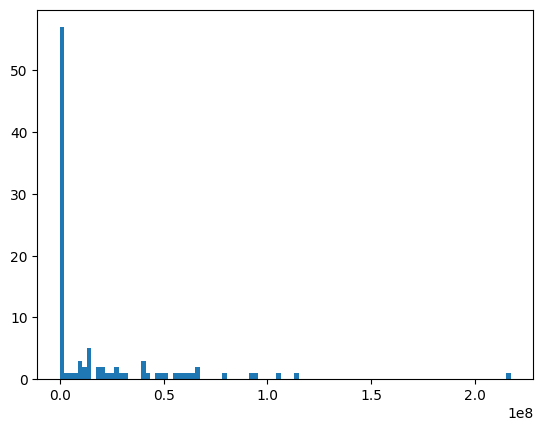

In [28]:
time_ns_raw = [msg[9] for msg in X_raw]
time_ns_raw
print("time_ns_raw:", time_ns_raw)
print("sum(time_ns_raw):", sum(time_ns_raw))

# # plot a scatter plot of the time_ns values
# plt.scatter(range(len(time_ns_raw)), time_ns_raw)

# plot a histogram of the time_ns values
plt.hist(time_ns_raw, bins=100)

time_ns_gen: [49430, 68712, 27974, 243908, 31345, 5205, 47295, 89295, 53113, 45058, 66356, 6622, 16580, 13841, 32267, 45984, 182341, 199110, 25933, 1138730, 16460, 36414, 3212, 271, 1114998, 44300714, 25997597, 42655119, 20893, 403380, 25843187, 33418275, 1078398, 52307708, 25222297, 20821842, 37658, 10036128, 13465126, 11873160, 111007, 0, 35004, 7110, 2177, 17911, 8483, 1129, 3395, 167639, 39001, 5426, 245, 2749, 11564, 4127, 6131, 10842, 15370, 3375, 10610, 4939, 5995, 20997, 116529, 144803, 15176, 103998, 5349, 44467, 182718, 118942, 27128, 925, 3120, 11414, 6362, 24343, 10579, 94398, 27581, 5969, 167373, 15475, 102223, 31336, 7464, 205697, 8134, 3137, 21622, 13357, 314, 11140, 2449, 12348, 59254, 76418, 48280, 2148, 23349, 7668, 31175, 63620, 58351, 119586, 29374, 78420, 16400, 48130, 143246]
sum(time_ns_gen): 313888451
off by a factor of: 5.856519260722976


(array([97.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([       0.        ,   523077.08      ,  1046154.16      ,
         1569231.24      ,  2092308.32      ,  2615385.4       ,
         3138462.48      ,  3661539.56      ,  4184616.64      ,
         4707693.72      ,  5230770.8       ,  5753847.88      ,
         6276924.96      ,  6800002.04      ,  7323079.12      ,
         7846156.2       ,  8369233.28      ,  8892310.36      ,
         9415387.44      ,  9938464.52      

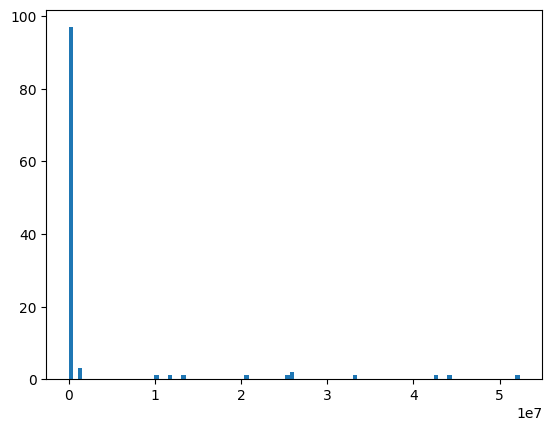

In [29]:
# extrat the ninth element of each message (time_ns)
time_ns_gen = [msg[9] for msg in decoded_x_gen]
time_ns_gen
print("time_ns_gen:", time_ns_gen)
print("sum(time_ns_gen):", sum(time_ns_gen))

sum(time_ns_raw) / sum(time_ns_gen)
print("off by a factor of:", sum(time_ns_raw) / sum(time_ns_gen))

# # plot a scatter plot of the time_ns values
# plt.scatter(range(len(time_ns_gen)), time_ns_gen)

# plot a histogram of the time_ns values
plt.hist(time_ns_gen, bins=100)

# time_s_gen = [msg[8] for msg in decoded_x_gen]
# time_s_gen
# sum(time_s_gen)

In [30]:
time

36314344584944

In [31]:
gen_start_time
time 

36314344584944

In [32]:
# # determine appropriate msg_seq_len for efficient block_size
# msg_seqL = 0
# # for i in range(1, 500):
# for i in range(1, 500):
#     msg_seqL = i
#     blk_size = msg_seqL*24 #- 1 # minus 1 for target rescaling
#     # if msg_seqL % 24 == 0:
#     if blk_size % 64 == 0 and blk_size % 24 == 0:
#         print(f"msg_seqL: {msg_seqL}, blk_size: {blk_size}")

# # msg_seqL: 112, blk_size: 2688

In [33]:
print("Number of sampling errors:", num_sampling_errors)
print("Number of symbol errors:", num_symbol_errors)
print("Number of order placement errors:", num_errors)
total_errors = num_sampling_errors + num_symbol_errors + num_errors
print("Total number of errors:", total_errors)
print("Error percentage:", round((total_errors / num_generation_steps) * 100, 2), "%")

Number of sampling errors: 3
Number of symbol errors: 0
Number of order placement errors: 2258
Total number of errors: 2261
Error percentage: 7.54 %


In [34]:
print("gen_start_time:", gen_start_time)
print("gen_end_time:", time)

sim_time_elapsed = time - gen_start_time
print("Simulation time elapsed (nanoseconds):", sim_time_elapsed)
print("Simulation time elapsed (seconds):", sim_time_elapsed / 1e9)
print("Simulation time elapsed (minutes):", sim_time_elapsed / 1e9 / 60)

gen_start_time: 36000809191345
gen_end_time: 36314344584944
Simulation time elapsed (nanoseconds): 313535393599
Simulation time elapsed (seconds): 313.535393599
Simulation time elapsed (minutes): 5.225589893316666


In [35]:
real_msg_per_sec = 70 # give or take, varies by time of day
sim_msg_per_sec = (num_generation_steps - total_errors) / (sim_time_elapsed / 1e9)
print("Real messages per second:", real_msg_per_sec)
print("Simulated messages per second:", sim_msg_per_sec)
# print("offset:", real_msg_per_sec / sim_msg_per_sec)

Real messages per second: 70
Simulated messages per second: 88.47167039609296


len(L1_gen): 27739


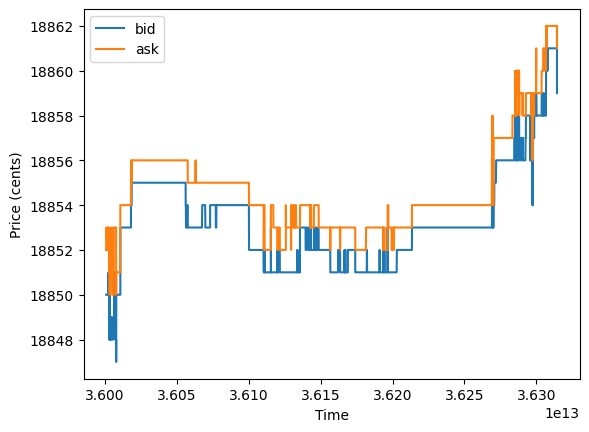

In [36]:
print("len(L1_gen):", len(L1_gen))

# plot L1_gen data
times = [L1_gen[i][0] for i in range(len(L1_gen))]
bids = [L1_gen[i][1][0] for i in range(len(L1_gen))]
asks = [L1_gen[i][2][0] for i in range(len(L1_gen))]
plt.plot(times, bids, label='bid')
plt.plot(times, asks, label='ask')

# # plot last 10000 time steps
# plt.plot(times[-10000:], bids[-10000:], label='bid')
# plt.plot(times[-10000:], asks[-10000:], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

len(last_prices_gen): 589


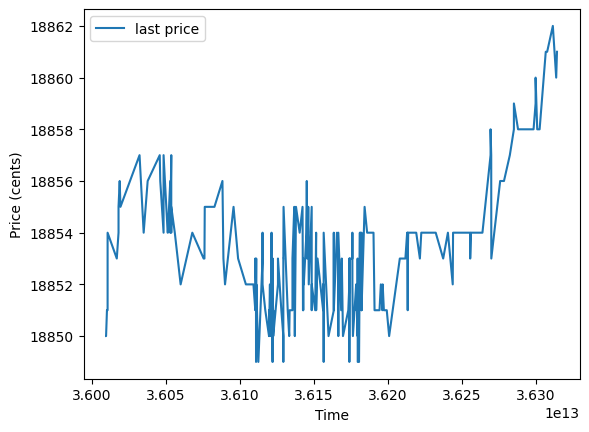

In [37]:
print("len(last_prices_gen):", len(last_prices_gen))

# plot last prices
times = [last_prices_gen[i][0] for i in range(len(last_prices_gen))]
prices = [last_prices_gen[i][1] for i in range(len(last_prices_gen))]
plt.plot(times, prices, label='last price')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

# TODO: put in *-minute buckets plot series

Total number of messages: 27739
Add Order percentage: 51.12 % (count: 14180 )
Execute Order percentage: 2.12 % (count: 589 )
Modified Execute Order percentage: 0.0 % (count: 0 )
Full Cancel Order percentage: 43.23 % (count: 11992 )
Partial Cancel Order percentage: 0.23 % (count: 65 )
Replace Order percentage: 3.29 % (count: 913 )


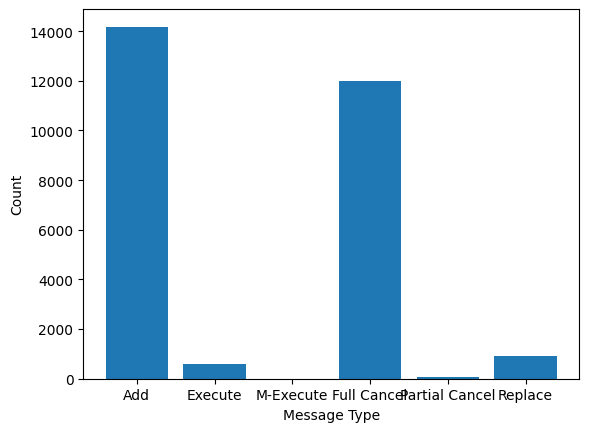

In [38]:
# print percentage of each message type
total_msgs = num_add_order_msgs + num_exec_order_msgs + num_execmod_order_msgs + num_full_cancel_order_msgs + num_partial_cancel_order_msgs + num_replace_order_msgs
print("Total number of messages:", total_msgs)
print("Add Order percentage:", round((num_add_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_add_order_msgs, ")")
print("Execute Order percentage:", round((num_exec_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_exec_order_msgs, ")")
print("Modified Execute Order percentage:", round((num_execmod_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_execmod_order_msgs, ")")
print("Full Cancel Order percentage:", round((num_full_cancel_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_full_cancel_order_msgs, ")")
print("Partial Cancel Order percentage:", round((num_partial_cancel_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_partial_cancel_order_msgs, ")")
print("Replace Order percentage:", round((num_replace_order_msgs / total_msgs) * 100, 2), "%", "(count:", num_replace_order_msgs, ")")

# plot message type counts
msg_types = ['Add', 'Execute', 'M-Execute', 'Full Cancel', 'Partial Cancel', 'Replace']
msg_counts = [num_add_order_msgs, num_exec_order_msgs, num_execmod_order_msgs, num_full_cancel_order_msgs, num_partial_cancel_order_msgs, num_replace_order_msgs]
plt.bar(msg_types, msg_counts)
# plt.rcParams['font.size'] = 8
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

# help?: https://stackoverflow.com/questions/26700598/matplotlib-showing-x-tick-labels-overlapping

In [44]:
msg_per_sec = 10
est_comp_time_1 = round((1596503 // msg_per_sec) / 60 / 60, 2)
est_comp_time_2 = round((1956673 // msg_per_sec) / 60 / 60, 2)
est_comp_time_3 = round((1960770 // msg_per_sec) / 60 / 60, 2)
est_comp_time_4 = round((1214806 // msg_per_sec) / 60 / 60, 2)
est_comp_time_5 = round((1151383 // msg_per_sec) / 60 / 60, 2)
est_comp_time_6 = round((739800 // msg_per_sec) / 60 / 60, 2)
est_comp_time_7 = round((1395511 // msg_per_sec) / 60 / 60, 2)
est_comp_time_8 = round((1484259 // msg_per_sec) / 60 / 60, 2)
off_rate_1 = round(est_comp_time_1 / 6.5, 2)
off_rate_2 = round(est_comp_time_2 / 6.5, 2)
off_rate_3 = round(est_comp_time_3 / 6.5, 2)
off_rate_4 = round(est_comp_time_4 / 6.5, 2)
off_rate_5 = round(est_comp_time_5 / 6.5, 2)
off_rate_6 = round(est_comp_time_6 / 6.5, 2)
off_rate_7 = round(est_comp_time_7 / 6.5, 2)
off_rate_8 = round(est_comp_time_8 / 6.5, 2)

print(f"estimated completion time (hr): {est_comp_time_1}, off by factor of {off_rate_1}x")
print(f"estimated completion time (hr): {est_comp_time_2}, off by factor of {off_rate_2}x")
print(f"estimated completion time (hr): {est_comp_time_3}, off by factor of {off_rate_3}x")
print(f"estimated completion time (hr): {est_comp_time_4}, off by factor of {off_rate_4}x")
print(f"estimated completion time (hr): {est_comp_time_5}, off by factor of {off_rate_5}x")
print(f"estimated completion time (hr): {est_comp_time_6}, off by factor of {off_rate_6}x")
print(f"estimated completion time (hr): {est_comp_time_7}, off by factor of {off_rate_7}x")
print(f"estimated completion time (hr): {est_comp_time_8}, off by factor of {off_rate_8}x")

estimated completion time (hr): 44.35, off by factor of 6.82x
estimated completion time (hr): 54.35, off by factor of 8.36x
estimated completion time (hr): 54.47, off by factor of 8.38x
estimated completion time (hr): 33.74, off by factor of 5.19x
estimated completion time (hr): 31.98, off by factor of 4.92x
estimated completion time (hr): 20.55, off by factor of 3.16x
estimated completion time (hr): 38.76, off by factor of 5.96x
estimated completion time (hr): 41.23, off by factor of 6.34x


#### Scratch paper

In [57]:
from equities.fast_model import apply_rotary_emb, repeat_kv, reshape_for_broadcast
import math

n_rep = model.params.n_heads // model.params.n_kv_heads

In [53]:
def apply_rotary_emb_single(
    x: torch.Tensor,
    freqs_cos: torch.Tensor,
    freqs_sin: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:

    # reshape x to match the complex representation
    x_r, x_i = x.float().reshape(x.shape[:-1] + (-1, 2)).unbind(-1)

    # reshape freqs_cos and freqs_sin for broadcasting
    freqs_cos = reshape_for_broadcast(freqs_cos, x_r)
    freqs_sin = reshape_for_broadcast(freqs_sin, x_r)

    # apply rotation using real numbers
    x_out_r = x_r * freqs_cos - x_i * freqs_sin
    x_out_i = x_r * freqs_sin + x_i * freqs_cos

    # flatten last two dimensions
    x_out = torch.stack([x_out_r, x_out_i], dim=-1).flatten(3)

    return x_out.type_as(x)

In [55]:
###### get xq tensor for next notebook cell stuff
x_i = x[:,-1].reshape(-1,1) # last token in sequence
print("x_i.shape:", x_i.shape)
print("x_i:", x_i)

input_pos = x.shape[1] - 1
print("input_pos:", input_pos)
_bsz, seqlen = x_i.shape # 1, 1

h = model.tok_embeddings(x_i)
print("h.shape:", h.shape)

freqs_cos = model.freqs_cos[input_pos:input_pos+seqlen]
freqs_sin = model.freqs_sin[input_pos:input_pos+seqlen]
print("freqs_cos.shape:", freqs_cos.shape)
print("freqs_sin.shape:", freqs_sin.shape)

x_input = model.layers[0].attention_norm(h)
print("x_input.shape:", x_input.shape)

xq = model.layers[0].attention.wq(x_input)
print("xq.shape:", xq.shape)

head_dim = model.params.dim // model.params.n_heads
xq = xq.view(_bsz, seqlen, model.params.n_heads, head_dim)
print("xq.shape:", xq.shape)

# xk_test = model.layers[0].attention.wk(x_input)
# xk_test = xk_test.view(_bsz, seqlen, model.params.n_kv_heads, head_dim)
# print("xk_test.shape:", xk_test.shape)
# assert xk_test.shape == xq.shape # passes test

xq = apply_rotary_emb_single(xq, freqs_cos, freqs_sin)
print("xq.shape:", xq.shape) # size unchanged

x_i.shape: torch.Size([1, 1])
x_i: tensor([[648]], device='cuda:0')
input_pos: 10319
h.shape: torch.Size([1, 1, 768])
freqs_cos.shape: torch.Size([1, 32])
freqs_sin.shape: torch.Size([1, 32])
x_input.shape: torch.Size([1, 1, 768])
xq.shape: torch.Size([1, 1, 768])
xq.shape: torch.Size([1, 1, 12, 64])
xq.shape: torch.Size([1, 1, 12, 64])


In [56]:
# msg_debug
print(model.kv_cache[0].key.shape)
print(model.kv_cache[0].value.shape)

xk = model.kv_cache[0].key
xv = model.kv_cache[0].value

bsz = 1
# start_pos = 10342
start_pos = input_pos
T = 1
xk = xk[:bsz, : start_pos + T]
xv = xv[:bsz, : start_pos + T]
print(xk.shape)
print(xv.shape)

xk = repeat_kv(xk, n_rep)
xv = repeat_kv(xv, n_rep)
print(xk.shape)
print(xv.shape)

# make heads into a batch dimension
xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
xk = xk.transpose(1, 2)
xv = xv.transpose(1, 2)
print("batch xq.shape:", xq.shape)
print("batch xk.shape:", xk.shape)
print("batch xv.shape:", xv.shape)

torch.Size([1, 10367, 12, 64])
torch.Size([1, 10367, 12, 64])
torch.Size([1, 10320, 12, 64])
torch.Size([1, 10320, 12, 64])
torch.Size([1, 10320, 12, 64])
torch.Size([1, 10320, 12, 64])
batch xq.shape: torch.Size([1, 12, 1, 64])
batch xk.shape: torch.Size([1, 12, 10320, 64])
batch xv.shape: torch.Size([1, 12, 10320, 64])


In [29]:
mask = torch.full((1, 1, model.params.max_seq_len, model.params.max_seq_len), float("-inf"), device=device)
mask = torch.triu(mask, diagonal=1)
print("mask.shape:", mask.shape)
mask

mask.shape: torch.Size([1, 1, 10368, 10368])


tensor([[[[0., -inf, -inf,  ..., -inf, -inf, -inf],
          [0., 0., -inf,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [0., 0., 0.,  ..., 0., -inf, -inf],
          [0., 0., 0.,  ..., 0., 0., -inf],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [43]:
# sliding window attention (swa) mask
# window_size = 5184 # 10368 / 2 = 5184, same formula used by mistral 7b for calculating window size (context_len / 2)
window_size = 5
# swa_mask = torch.full((1, 1, model.params.max_seq_len, model.params.max_seq_len), float("-inf"), device=device)
swa_mask = torch.full((1, 1, 20, 20), float("-inf"), device=device)
swa_mask = torch.triu(swa_mask, diagonal=1)
swa_mask = torch.triu(swa_mask, diagonal=-window_size)
# not correct, follow method used here?: https://github.com/lucidrains/local-attention/blob/master/local_attention/local_attention.py
print("swa_mask.shape:", swa_mask.shape)
swa_mask

swa_mask.shape: torch.Size([1, 1, 20, 20])


tensor([[[[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [0., 0

In [36]:
8192 // 32
# 8192 / 4096
# 10368 // 32
10368 / 2 
# 5184 // 32

162

In [64]:
# self-attention
with torch.no_grad():
    scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(head_dim)
    # assert hasattr(self, 'mask')
    scores = scores + mask[:, :, :seqlen, :seqlen]   # (bs, n_local_heads, seqlen, cache_len + seqlen)
print("scores.shape:", scores.shape)
scores
# scores = torch.nn.functional.softmax(scores.float(), dim=-1).type_as(xq)
# output = torch.matmul(scores, xv)  # (bs, n_local_heads, seqlen, head_dim)

scores.shape: torch.Size([1, 12, 1, 10320])


tensor([[[[-2.6003e-01,  3.8623e-01,  3.3498e-01,  ..., -2.3681e-01,
            6.6732e-01, -2.1959e-01]],

         [[-3.8998e+00, -5.8728e-01,  2.5227e-01,  ...,  3.9170e-01,
            3.4713e-01, -4.4018e-01]],

         [[-1.5059e-01, -1.2565e-01,  1.3263e+00,  ..., -9.3774e-02,
            4.8610e-01, -1.5962e-01]],

         ...,

         [[-7.2178e-01,  2.9351e-03, -1.5578e+00,  ..., -3.4302e-02,
           -2.4721e-02,  1.3784e-02]],

         [[ 7.6198e-01, -1.1262e+00, -3.2533e+00,  ...,  1.9666e+00,
           -9.6419e-01,  9.7348e-01]],

         [[ 1.0758e+00,  2.6840e+00,  6.1702e-01,  ...,  8.0292e-01,
           -4.1793e-01,  2.8338e-01]]]], device='cuda:0')

In [24]:
past_key = model.kv_cache[0].key
past_value = model.kv_cache[0].value
print(past_key.shape)

# sliding window kv cache
slicing_tokens = 1
sw_key = (past_key[:, slicing_tokens:, :, :])
print(sw_key.shape)

torch.Size([1, 10343, 12, 64])
torch.Size([1, 10342, 12, 64])


In [25]:
# streaming_llm kv cache
sink_tokens = 0 # 24

sink_side = past_key[:, 0:sink_tokens, :, :]
print(sink_side.shape)
# recent_side = past_key[:, sink_tokens:, :, :] # remove an additional 24 tokens for new message?
# in theory, would be better to remove one token as a time, since we would be able to use more context at a time
recent_side = past_key[:, (sink_tokens + encoded_tok_len):, :, :]
print(recent_side.shape)

stream_key = torch.cat((sink_side, recent_side), dim=1)
print(stream_key.shape)

torch.Size([1, 0, 12, 64])
torch.Size([1, 10319, 12, 64])
torch.Size([1, 10319, 12, 64])


In [87]:
# apply position transromation to keys
cache_size = stream_key.shape[1]
print(cache_size)
# freqs_cos_cache = model.freqs_cos[:cache_size]
# freqs_sin_cache = model.freqs_sin[:cache_size]
# print(freqs_cos_cache.shape)
# print(freqs_sin_cache.shape)
freq_cache = (model.freqs_cos[:cache_size], model.freqs_sin[:cache_size])
freqs_cos_cache, freqs_sin_cache = freq_cache
print(freqs_cos_cache.shape)
print(freqs_sin_cache.shape)

stream_key = apply_rotary_emb_single(stream_key, freqs_cos_cache, freqs_sin_cache)
print(stream_key.shape)

10367
torch.Size([10367, 32])
torch.Size([10367, 32])
torch.Size([1, 10367, 12, 64])


In [20]:
test_freq = torch.arange(24)
print(test_freq.shape)
print(test_freq)

fr1 = test_freq[14:14+1]
print(fr1.shape)
print(fr1)

fr2 = test_freq[:14+1]
print(fr2.shape)
print(fr2)

test_freq[0:24]
test_freq[10:].roll(-5)

torch.Size([24])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23])
torch.Size([1])
tensor([14])
torch.Size([15])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 10, 11, 12, 13, 14])

In [27]:
nasdaq_agent.messages[-1]

(1,
 OrderCancelledMsg(message_id=19059, order=(Agent 1 @ 1970-01-01 09:30:25) : BID 100 AAPL @ $188.80))

In [35]:
vars(nasdaq_agent.messages[-2][1].order) #.time_placed #.order_id

{'agent_id': 1,
 'time_placed': 34224470830282,
 'symbol': 'AAPL',
 'quantity': 100,
 'side': <Side.BID: 'BID'>,
 'order_id': 54,
 'fill_price': 18880,
 'tag': None,
 'limit_price': 18880,
 'is_hidden': False,
 'is_price_to_comply': False,
 'insert_by_id': False,
 'is_post_only': False}

In [66]:
top_k = None
print("x.shape:", x.shape)
print("x:", x)
print("temperature:", temperature)
print("top_k:", top_k)

from torch.nn import functional as F

idx = x
B,T = idx.shape
input_pos = idx.shape[1] - 1
KVCACHE = True
start = False
roll = False
new_block_size = 2688

top_p = 0.9

# if the sequence context is growing too long we must crop it at block_size
idx_cond = idx # if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
# forward the model to get the logits for the index in the sequence
if KVCACHE and not start:
    x_idx = idx_cond[:,-1].reshape(-1,1)
else:
    x_idx = idx_cond
    input_pos = 0
print("input_pos:", input_pos)
print("x_idx.shape:", x_idx.shape)
logits = model.forward(x_idx, None, kv_cache=KVCACHE, max_seq_length=new_block_size, input_pos=input_pos, roll=roll)
print("logits.shape:", logits.shape)
logits = logits[:, -1, :] # crop to just the final time step
print("logits.shape:", logits.shape)
print("logits:", logits)

if temperature == 0.0: # greedy sampling:
    # "sample" the single most likely index
    _, idx_next = torch.topk(logits, k=1, dim=-1)
else:
    # pluck the logits at the final step and scale by desired temperature
    logits = logits / temperature
    # optionally crop the logits to only the top k options
    if top_k is not None:
        v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        logits[logits < v[:, [-1]]] = -float('Inf')
    if top_p > 0.0:
        # First sort and calculate cumulative sum of probabilities.
        sorted_logits, sorted_indices = torch.sort(logits, descending=False)
        cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
        # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(
            1, sorted_indices, sorted_indices_to_remove
        )
        logits.masked_fill_(indices_to_remove, float("-inf"))
    # apply softmax to convert logits to (normalized) probabilities
    probs = F.softmax(logits, dim=-1)
    idx_next = torch.multinomial(probs, num_samples=1)
print("idx_next.shape:", idx_next.shape)
print("idx_next:", idx_next)

# input_pos = idx.shape[1]
# start = False
# roll = False
# # append sampled index to the running sequence and continue
# idx = torch.cat((idx, idx_next), dim=1)


# for _ in range(max_new_tokens*encoded_tok_len):
#     with torch.no_grad():
#         # forward the model to get the logits for the index in the sequence
#         logits, _ = model(idx)
#         # pluck the logits at the final step and scale by desired temperature
#         logits = logits[:, -1, :] / temperature
#         # optionally crop the logits to only the top k options
#         if top_k is not None:
#             v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#             logits[logits < v[:, [-1]]] = -float('Inf')
#         # apply softmax to convert logits to (normalized) probabilities
#         probs = F.softmax(logits, dim=-1)
#         # sample from the distribution
#         idx_next = torch.multinomial(probs, num_samples=1)
#         # append sampled index to the running sequence and continue
#         idx = torch.cat((idx, idx_next), dim=1)

#         print("idx_next:", idx_next)

# print("last generated msg:", idx[0][-24:].tolist())

x.shape: torch.Size([1, 2401])
x: tensor([[    1, 12051,  1003,  ...,   229,   329,   580]], device='cuda:0')
temperature: 1.0
top_k: None
input_pos: 2400
x_idx.shape: torch.Size([1, 1])
logits.shape: torch.Size([1, 1, 12515])
logits.shape: torch.Size([1, 12515])
logits: tensor([[-7.0298, -3.1519,  1.7736,  ..., -6.4578, -6.4962, -5.7820]],
       device='cuda:0', grad_fn=<SliceBackward0>)
idx_next.shape: torch.Size([1, 1])
idx_next: tensor([[722]], device='cuda:0')


In [62]:
print("logits:", logits)

# First sort and calculate cumulative sum of probabilities.
sorted_logits, sorted_indices = torch.sort(logits, descending=False)
sorted_logits, sorted_indices
cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
cumulative_probs
# Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
sorted_indices_to_remove = cumulative_probs <= (1 - top_p)
sorted_indices_to_remove
# scatter sorted tensors to original indexing
indices_to_remove = sorted_indices_to_remove.scatter(
    1, sorted_indices, sorted_indices_to_remove
)
indices_to_remove
logits.masked_fill_(indices_to_remove, float("-inf"))

logits: tensor([[-7.0298, -3.1519,  1.7736,  ..., -6.4578, -6.4962, -5.7820]],
       device='cuda:0', grad_fn=<SliceBackward0>)


tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0',
       grad_fn=<AsStridedBackward0>)

In [61]:
print("logits:", logits)

sorted_logits, sorted_indices = torch.sort(logits, descending=True)
# print("sorted_logits.shape:", sorted_logits.shape)
# print("sorted_indices.shape:", sorted_indices.shape)
sorted_logits, sorted_indices
cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
# print("cumulative_probs.shape:", cumulative_probs.shape)
cumulative_probs

# Remove tokens with cumulative probability above the threshold
sorted_indices_to_remove = cumulative_probs >= top_p
# Shift the indices to the right to keep also the first token above the threshold
sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
sorted_indices_to_remove[..., 0] = 0

# scatter sorted tensors to original indexing
indices_to_remove1 = torch.zeros_like(logits, dtype=sorted_indices_to_remove.dtype).scatter_(
    dim=-1, index=sorted_indices, src=sorted_indices_to_remove )
indices_to_remove1
# indices_to_remove2 = sorted_indices_to_remove.scatter(
#     1, sorted_indices, sorted_indices_to_remove
# )
# indices_to_remove2[:, -20:]
# logits[indices_to_remove1] = -float('Inf')
# logits 

logits: tensor([[-7.0298, -3.1519,  1.7736,  ..., -6.4578, -6.4962, -5.7820]],
       device='cuda:0', grad_fn=<SliceBackward0>)
sorted_indices_to_remove.shape: torch.Size([1, 12515])


tensor([[True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
# @torch.inference_mode()
# def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, start=False, roll=False, new_block_size=10344):
#     """
#     Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
#     the sequence max_new_tokens times, feeding the predictions back into the model each time.
#     Most likely you'll want to make sure to be in model.eval() mode of operation for this.
#     """
#     B,T = idx.shape
#     # input_pos = 0
#     input_pos = idx.shape[1] - 1
#     for _ in range(max_new_tokens):
#         # if the sequence context is growing too long we must crop it at block_size
#         idx_cond = idx if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
#         # forward the model to get the logits for the index in the sequence
#         if KVCACHE and not start:
#             x = idx_cond[:,-1].reshape(-1,1)
#         else:
#             x = idx_cond
#             input_pos = 0
#         # print("input_pos:", input_pos)
#         # logits = self.forward(x, None, kv_cache=KVCACHE, max_seq_length=max_new_tokens, input_pos=input_pos)
#         # logits = self.forward(x, None, kv_cache=KVCACHE, max_seq_length=self.params.max_seq_len, input_pos=input_pos, roll=roll)
#         logits = self.forward(x, None, kv_cache=KVCACHE, max_seq_length=new_block_size, input_pos=input_pos, roll=roll)
#         logits = logits[:, -1, :] # crop to just the final time step
#         if temperature == 0.0: # greedy sampling:
#             # "sample" the single most likely index
#             _, idx_next = torch.topk(logits, k=1, dim=-1)
#         else:
#             # pluck the logits at the final step and scale by desired temperature
#             logits = logits / temperature
#             # optionally crop the logits to only the top k options
#             if top_k is not None:
#                 v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#                 logits[logits < v[:, [-1]]] = -float('Inf')
#             # apply softmax to convert logits to (normalized) probabilities
#             probs = F.softmax(logits, dim=-1)
#             idx_next = torch.multinomial(probs, num_samples=1)
#         input_pos = idx.shape[1]
#         start = False
#         roll = False
#         # append sampled index to the running sequence and continue
#         idx = torch.cat((idx, idx_next), dim=1)

#     return idx